# **Learning From the Imbalanced Data**

We have seen that the prediction from the imbalanced data favors the majority class (birth natality). Various undersampling and oversampling methods are used to deal will the the data imbalance inherent in the natality-infant fatality dataset. In this notebook, I use Synthetic Minority Over-sampling Technique (SMOTE) to balance the positive-to-negative label proportion by over-sampling the minoriy class. The training dataset is oversampled using SMOTE after splitting the whole dataset into training/test datasets.

In [19]:
import matplotlib
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
Data_2008 = pd.read_pickle('CleanData_ML_final')

In [3]:
Data_2008.rename(columns=lambda x: x.strip(),inplace = True)

In [4]:
attribute_list = list(Data_2008.columns.str.strip()) #strip in case some of the column names have spaces around them.
print(attribute_list)

['AB_ANTI', 'AB_AVEN1', 'AB_AVEN6', 'AB_BINJ', 'AB_NICU', 'AB_SEIZ', 'AB_SURF', 'APGAR5', 'ATTEND', 'BFACIL', 'BRTHWGT', 'CA_ANEN', 'CA_CCHD', 'CA_CDH', 'CA_CLEFT', 'CA_CLPAL', 'CA_DISOR', 'CA_DOWN', 'CA_GAST', 'CA_HYPO', 'CA_LIMB', 'CA_MNSB', 'CA_OMPH', 'CIG_1', 'CIG_2', 'CIG_3', 'CIG_REC', 'COMBGEST', 'DMETH_REC', 'DPLURAL', 'ESTGEST', 'FAGECOMB', 'FBRACE', 'FLGND', 'FRACEHISP', 'LBO', 'LD_ANES', 'LD_ANTI', 'LD_AUGM', 'LD_CHOR', 'LD_FINT', 'LD_INDL', 'LD_MECS', 'LD_NVPR', 'LD_STER', 'MAGER', 'MAR', 'MBRACE', 'MEDUC', 'ME_ATTF', 'ME_ATTV', 'ME_PRES', 'ME_ROUT', 'ME_TRIAL', 'MRACEHISP', 'MRACEREC', 'ON_PRECIP', 'ON_PROL', 'ON_RUPTR', 'OP_CERV', 'OP_ECVF', 'OP_ECVS', 'OP_TOCOL', 'PRECARE', 'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'RF_CESARN', 'RF_DIAB', 'RF_ECLAM', 'RF_GEST', 'RF_GHYP', 'RF_PHYP', 'RF_PPOUTC', 'RF_PPTERM', 'SEX', 'TBO', 'UBFACIL', 'UCA_ANEN', 'UCA_CELFTLP', 'UCA_DOWNS', 'UCA_OMPHA', 'UCA_SPINA', 'UFHISP', 'ULD_BREECH', 'ULD_MECO', 'ULD_PRECIP', 'UME_FORCP', 'UME_VAC', 'UMH

In [5]:
len(attribute_list)

98

### Categorical, numerical, and binary features

Make a list of categorical, numerical, and binary features. The aim is to apply encode the categorical features. After data cleaning, there are 102 features and 1,569,762 records in total. Out of these, there are 25 categorical, 17 numerical, and 60 binary features.

In [6]:
categorical_attribute = ['ATTEND','BFACIL','DMETH_REC','FBRACE','FRACEHISP','MBRACE',
                         'ME_PRES','ME_ROUT','ME_TRIAL','MRACEHISP','MRACEREC','RDMETH_REC','RESTATUS',
                        'UBFACIL','UCA_ANEN','UCA_CELFTLP','UCA_DOWNS','UCA_OMPHA','UCA_SPINA',
                        'UFHISP','UMHISP']

In [7]:
numerical_attribute = ['APGAR5','BRTHWGT','CIG_1','CIG_2','CIG_3','COMBGEST','DPLURAL','ESTGEST','FAGECOMB','LBO','MAGER',
                      'MEDUC','PRECARE','RF_CESARN','TBO','UPREVIS','WTGAIN']

In [8]:
binary_attribute = ['AB_ANTI','AB_AVEN1','AB_AVEN6','AB_BINJ','AB_NICU','AB_SEIZ','AB_SURF','CA_ANEN','CA_CCHD',
                   'CA_CDH','CA_CLEFT','CA_CLPAL','CA_DISOR','CA_DOWN','CA_GAST','CA_HYPO','CA_LIMB','CA_MNSB',
                   'CA_OMPH','CIG_REC','FLGND','LD_ANES','LD_ANTI','LD_AUGM','LD_CHOR','LD_FINT','LD_INDL','LD_MECS',
                   'LD_NVPR','LD_STER','MAR','ME_ATTF','ME_ATTV','ON_PRECIP','ON_PROL','ON_RUPTR','OP_CERV',
                   'OP_ECVF','OP_ECVS','OP_TOCOL','RF_CESAR','RF_DIAB','RF_ECLAM','RF_GEST','RF_GHYP','RF_PHYP',
                   'RF_PPOUTC','RF_PPTERM','SEX','ULD_BREECH','ULD_MECO','ULD_PRECIP','UME_FORCP','UME_VAC',
                    'UOP_INDUC','UOP_TOCOL','URF_CHYPER','URF_DIAB','URF_ECLAM','URF_PHYPER']

Convert the numerical and binary features to float and int types respectively

In [9]:
for i in numerical_attribute:
    Data_2008['%s' % i] = Data_2008['%s' % i].astype(float)

In [10]:
for j in binary_attribute:
    Data_2008['%s' % j] = Data_2008['%s' % j].astype(int)

Encode the categorical features and assign a name to each new derived column 

In [11]:
df = pd.get_dummies(Data_2008, prefix=categorical_attribute, columns=categorical_attribute)
df.shape

(1569762, 192)

Lets look at the number of positive (death) and negative (natality) data size

In [12]:
Data_2008['FLGND'].value_counts()

0    1562931
1       6831
Name: FLGND, dtype: int64

In [13]:
df_features = list(df.columns)
df_features.remove('FLGND')

In [14]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from imblearn.datasets import make_imbalance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [15]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [16]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.9,
                test_size=0.1):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size,test_size=test_size,stratify=y)
    print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
    Xtrain_resampled, ytrain_resampled = SMOTE().fit_sample(Xtrain, ytrain)
    print(Xtrain_resampled.shape, ytrain_resampled.shape)
    clf = cv_optimize(clf, parameters, Xtrain_resampled, ytrain_resampled)
    clf=clf.fit(Xtrain_resampled, ytrain_resampled)
    training_accuracy = clf.score(Xtrain_resampled, ytrain_resampled)
    test_accuracy = clf.score(Xtest, ytest)
    y_score = clf.decision_function(Xtest)
    ytrain_score = clf.decision_function(Xtrain_resampled)
    test_average_precision = average_precision_score(ytest, y_score)
    train_average_precision = average_precision_score(ytrain_resampled, ytrain_score)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print('Average test precision score: {0:0.2f}'.format(test_average_precision))
    print('Average train precision score: {0:0.2f}'.format(train_average_precision))
    return clf, Xtrain_resampled, ytrain_resampled, Xtest, ytest,y_score,ytrain_score

In [17]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l,yscore_1,ytrain_score_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1]}, 
                                                           df, df_features, 'FLGND',1)

(1412785, 191) (156977, 191) (1412785,) (156977,)
(2813274, 191) (2813274,)
BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.84
Accuracy on test data:     0.92
Average test precision score: 0.32
Average train precision score: 0.93


### Confusion matrix for test data

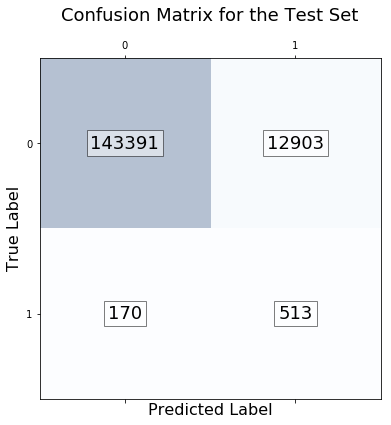

In [20]:
from matplotlib import rcParams
confmat_test = confusion_matrix(ytest_l, clf_l.predict(Xtest_l))
rcParams['axes.titlepad'] = 20 
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center',fontsize=18,bbox=dict(facecolor='white', alpha=0.5))
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Predicted Label',size=16)
plt.ylabel('True Label',size=16)
plt.title('Confusion Matrix for the Test Set',size=18)
plt.tight_layout()
plt.savefig('SMOTE_confusion_matrix_test.eps',format = 'eps',dpi = 1300)
plt.show()

Lets look at the percentage of positive and negative observations in both training and test datasets.

In [21]:
SS_train = Xtrain_l.shape[0] 
SS_test = Xtest_l.shape[0]
PP_train = round(np.sum(ytrain_l)/SS_train,3)
NP_train = round(np.sum(ytrain_l == 0)/SS_train,3)
PP_test = round(np.sum(ytest_l)/SS_test,3)
NP_test = round(np.sum(ytest_l == 0)/SS_test,3)

In [22]:
TN_test, FP_test, FN_test, TP_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l)).ravel()

In [23]:
print(TN_test,TP_test,FP_test,FN_test)

143391 513 12903 170


In [24]:

TPR_test = round(TP_test/(TP_test+FN_test),3) #true positive rate (Recall)

TNR_test = round(TN_test/(TN_test+FP_test),3) #true negative rate (Specifity)

PPV_test = round(TP_test/(TP_test+FP_test),3) #positive predictive value (Precision)

NPV_test = round(TN_test/(TN_test+FN_test),3) # Negative predictive value

FPR_test = round(FP_test/(FP_test+TN_test),3) # Fall out or false positive rate

FNR_test = round(FN_test/(TP_test+FN_test),3) # False negative rate

FDR_test = round(FP_test/(TP_test+FP_test),3) # False discovery rate

ACC_test = round((TP_test+TN_test)/(TP_test+FP_test+FN_test+TN_test),3) # Overall accuracy

In [25]:
print(classification_report(ytest_l, clf_l.predict(Xtest_l)))

             precision    recall  f1-score   support

          0       1.00      0.92      0.96    156294
          1       0.04      0.75      0.07       683

avg / total       0.99      0.92      0.95    156977



**Precision-Recall Curve**

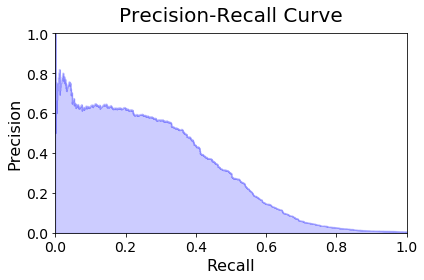

In [26]:
from sklearn.metrics import precision_recall_curve
precision_test, recall_test, _ = precision_recall_curve(ytest_l, yscore_1)
rcParams['axes.titlepad'] = 12 
plt.step(recall_test, precision_test, color='b', alpha=0.2,where='post')
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2,color='b')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Recall',size=16)
plt.ylabel('Precision',size=16)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve',size=20)
plt.tight_layout()
plt.savefig('SMOTE_precision_recall_test.png',format = 'png')

In [27]:
Xtrain_l.shape, ytrain_l.shape, Xtest_l.shape, ytest_l.shape

((2813274, 191), (2813274,), (156977, 191), (156977,))

***Receiver Operating Characteristic***

In [28]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, _ = roc_curve(ytest_l, yscore_1)
roc_auc = auc(fpr1, tpr1)
#print(fpr)

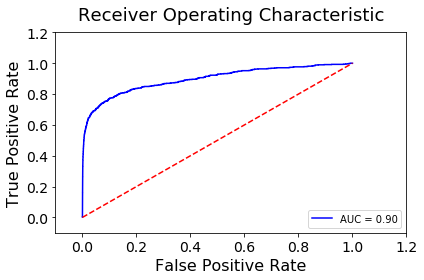

In [29]:
from sklearn.metrics import roc_curve, auc
fpr1_test, tpr1_test, _ = roc_curve(ytest_l, yscore_1)
roc_auc_test = auc(fpr1_test, tpr1_test)
#print(fpr)
plt.title('Receiver Operating Characteristic',size=18)
plt.plot(fpr1_test, tpr1_test, 'b',label='AUC = %0.2f'% roc_auc_test)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
rcParams['axes.titlepad'] = 20 
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate',size=16)
plt.xlabel('False Positive Rate',size=16)
plt.tight_layout()
plt.savefig('SMOTE_ROC_test.eps',format = 'eps',dpi = 1300)
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l))
print(cm_test)
cmt_test = pd.DataFrame(cm_test)

[[143391  12903]
 [   170    513]]


### Confusion matrix for training data

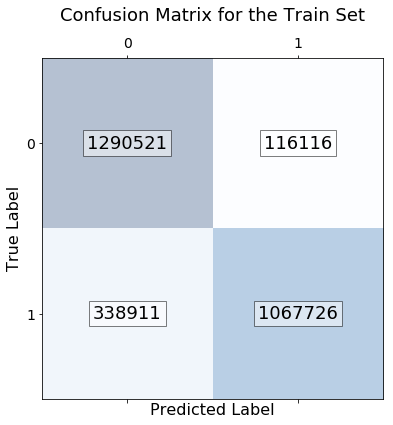

In [31]:
confmat_train = confusion_matrix(ytrain_l, clf_l.predict(Xtrain_l))
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.3)
#ax.grid(color='r', linestyle='-', linewidth=2)
for i in range(confmat_train.shape[0]):
    for j in range(confmat_train.shape[1]):
        ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center',fontsize=18,bbox=dict(facecolor='white', alpha=0.5))
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Predicted Label',size=16)
plt.ylabel('True Label',size=16)
plt.title('Confusion Matrix for the Train Set',size=18)
plt.tight_layout()
plt.savefig('SMOTE_Confusion_matrix_train.eps',format = 'eps',dpi = 1300)
plt.show()

In [32]:
TN_train,FP_train,FN_train,TP_train = confusion_matrix(ytrain_l,clf_l.predict(Xtrain_l)).ravel()

In [33]:
print(TN_train,TP_train,FP_train,FN_train)

1290521 1067726 116116 338911


In [34]:
TPR_train = round(TP_train/(TP_train+FN_train),3) #true positive rate (Recall)

TNR_train = round(TN_train/(TN_train+FP_train),3) #true negative rate (Specifity)

PPV_train = round(TP_train/(TP_train+FP_train),3) #positive predictive value (Precision)

NPV_train = round(TN_train/(TN_train+FN_train),3) # Negative predictive value

FPR_train = round(FP_train/(FP_train+TN_train),3) # Fall out or false positive rate

FNR_train = round(FN_train/(TP_train+FN_train),3) # False negative rate

FDR_train = round(FP_train/(TP_train+FP_train),3) # False discovery rate

ACC_train = round((TP_train+TN_train)/(TP_train+FP_train+FN_train+TN_train),3) # Overall accuracy

In [35]:
print(classification_report(ytrain_l, clf_l.predict(Xtrain_l)))

             precision    recall  f1-score   support

          0       0.79      0.92      0.85   1406637
          1       0.90      0.76      0.82   1406637

avg / total       0.85      0.84      0.84   2813274



**Precision-Recall Curve**

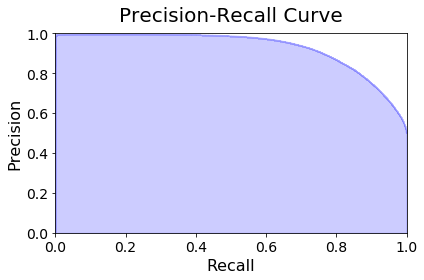

In [36]:
from sklearn.metrics import precision_recall_curve
precision_train, recall_train, _ = precision_recall_curve(ytrain_l, ytrain_score_l)
rcParams['axes.titlepad'] = 12 
plt.step(recall_train, precision_train, color='b', alpha=0.2,where='post')
plt.fill_between(recall_train, precision_train, step='post', alpha=0.2,color='b')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Recall',size=16)
plt.ylabel('Precision',size=16)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve',size=20)
plt.tight_layout()
plt.savefig('SMOTE_Precision_Recall_train.png',format = 'png')

***Receiver Operating Characteristic***

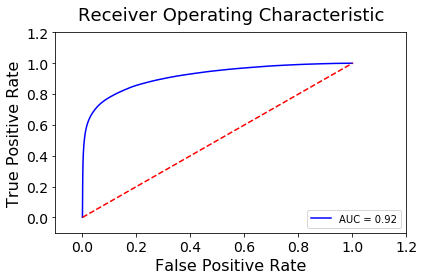

In [37]:
fpr1_train, tpr1_train, _ = roc_curve(ytrain_l, ytrain_score_l)
roc_auc_train = auc(fpr1_train, tpr1_train)
plt.title('Receiver Operating Characteristic',size=18)
plt.plot(fpr1_train, tpr1_train, 'b',label='AUC = %0.2f'% roc_auc_train)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
rcParams['axes.titlepad'] = 20 
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate',size=16)
plt.xlabel('False Positive Rate',size=16)
plt.tight_layout()
plt.savefig('SMOTE_ROC_train.eps',format = 'eps',dpi = 1300)
plt.show()

In [38]:
performance_data = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train,NP_train,SS_train,ACC_train,PPV_train,TPR_train,TNR_train],
                             ['Test Set',PP_test,NP_test,SS_test,ACC_test,PPV_test,TPR_test,TNR_test]])

In [39]:
performance_table = pd.DataFrame(data=performance_data[1:,1:],
                      index=performance_data[1:,0],
                      columns=performance_data[0,1:])

In [40]:

performance_table

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.5,0.5,2813274,0.838,0.902,0.759,0.917
Test Set,0.004,0.996,156977,0.917,0.038,0.751,0.917


The table above shows that the training data set is balanced (due to resampling) with the positive (PP) and negative (NP) label proportion of 0.5. Since the test dataset is not resampled, it is imblanaced, reflecting the original dataset, with positive proportion and negative proportion of 0.004 and 0.996 respectively. All four of the metrics (Accuracy = 0.838, Precision = 0.902, Recall = 0.759, TNR = 0.917) show a good performance of the classifier on the training dataset. For the test datasets, three metrics (Accuracy = 0.917, Recall = 0.751, TNR = 0.917) show a good average performance of the classifier on the test data. However, the precision (Precision = 0.038) is low, since there are high number of false negative values due to the data imbalance in the test dataset. 